# Model Inference

This notebook is designed for use with models pretrained using Jupyter notebooks or terminal scripts. It will load a pretrained model and perform predictions.

In [2]:

import matplotlib.pyplot as plt
import torch
from swincell.utils.utils import load_default_config
from swincell.utils.data_utils import flow_reshaped, split_dataset
# import warnings
# warnings.filterwarnings('ignore')


/home/xzhang/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configure training parameters

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = '../../colon_dataset/colon_demo/'
args =load_default_config()
args.data_dir=data_dir
args.dataset = 'colon'
# args.roi_x = 128
# args.roi_y = 128
# args.roi_z = 32
# args.max_epochs = 1000
# args.a_min = 0
# args.a_max = 255

args.downsample_factor = 1 # downsample the input image if resolution is too high





In [5]:


_,_,test_datalist = split_dataset(data_dir, split_ratios=[0,0,1])
# train_datalist, val_datalist, test_datalist = split_dataset(data_dir, split_ratios=[0.6,0.2,0.2])
print(len(test_datalist))




5


In [4]:
# from swincell.utils.data_utils import folder_loader
# train_loader,val_loader = folder_loader(args)

folder loader for tiff images
length of train/valid 4 4 1 1


## visualize training data

In [6]:

from swincell.utils.utils import load_model

# from torch.nn import MSELoss,BCEWithLogitsLoss
# from monai.losses import DiceLoss

model = load_model(args).to(device)

# loss1 = MSELoss(reduction='mean')
# loss2 = DiceLoss(to_onehot_y=False, sigmoid=True)
# losses = [loss1,loss2]

# optimizer = torch.optim.Adam(model.parameters(), lr=args.optim_lr, weight_decay=1e-5)

In [7]:
# load model
# save_model_name = 'demo_model.pt'
# model_dict = torch.load(save_model_name)["state_dict"]
# model.load_state_dict(model_dict)

predefined_model_path = '/home/xzhang/Projects/swincell_backup/runs/colon_cellpose_swinunetr_128_128_32_v2_1_255_colon_30/foldNone/model_final.pt'
model_dict = torch.load(predefined_model_path)["state_dict"]
model.load_state_dict(model_dict)

<All keys matched successfully>

# Data inference with the trained model

In [8]:
import numpy as np
import os
infer_ROI = (256,256,32)
output_folder = data_dir + 'output/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)


In [9]:
if args.dataset =='colon':

    img_shape= (1300,1030,129) #original shape
    img_reshape = (img_shape[0]//args.downsample_factor,img_shape[1]//args.downsample_factor,img_shape[2]//args.downsample_factor)
    img_reshape = tuple(int(e) for e in img_reshape)

elif args.dataset =='allen':

    img_shape=(900,600,64)
    img_reshape = (img_shape[0]//args.downsample_factor,img_shape[1]//args.downsample_factor,img_shape[2]//args.downsample_factor)
    img_reshape = tuple(int(e) for e in img_reshape)

elif args.dataset =='nanolive':

    img_shape=(512,512,96)
    img_reshape = (img_shape[0]//args.downsample_factor,img_shape[1]//args.downsample_factor,img_shape[2]//args.downsample_factor)
    img_reshape = tuple(int(e) for e in img_reshape)

else:
    raise Warning("dataset not defined")
    img_reshape = None

In [13]:
from monai import data, transforms


test_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image"]),
            transforms.EnsureChannelFirstd(keys=["image"]),
            # flow_reshaped(keys=["label"]),
            transforms.Resized(keys=["image"],spatial_size=img_reshape),
            transforms.ScaleIntensityRanged(
                keys=["image"], a_min=args.a_min, a_max=args.a_max, b_min=args.b_min, b_max=args.b_max, clip=True
            ),

            transforms.ToTensord(keys=["image"]),
        ]
    )

test_ds = data.Dataset(data=test_datalist[:1], transform=test_transform)
test_loader = data.DataLoader(
        test_ds, batch_size=1, sampler=None, drop_last=False
    )

In [14]:
from monai.transforms import (
    AsDiscrete,
    Activations,
)
from functools import partial
from monai.inferers import sliding_window_inference
import tifffile
from swincell.cellpose_dynamics import compute_masks

model_inferer = partial(
    sliding_window_inference,
    roi_size=infer_ROI,
    sw_batch_size=2,
    predictor=model,
    overlap=0.5,
    mode='gaussian'
)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
with torch.no_grad():
        for idx, batch_data in enumerate(test_loader):
        # for idx, batch_data in enumerate(train_loader):
            out_filename = test_datalist[idx]['image'].split('.')[0].split('/')[-1] +'_pred.tiff' 
            data_test = batch_data["image"]
            data_test = data_test.cuda(device)
            logits = model_inferer(data_test)         

            logits_out =  np.squeeze(logits.detach().cpu().numpy())
            
            print('logits shape',logits_out.shape)

            # logits_out_transposed = np.transpose(logits_out,(0,3,2,1))
            print('logits shape',logits_out.shape)
            logits_out[0] = post_pred(post_sigmoid(logits_out[0]))

            logits_out_transposed = np.transpose(logits_out,(0,3,2,1))
            flows = logits_out[1:4,:,:,:]
            print(flows.max(),flows.min())
            # masks_recon,p = compute_masks(logits_out[1:4,:,:,:],logits_out[0,:,:,:],cellprob_threshold=0.0,flow_threshold=0, do_3D=True)
            # masks_recon,p = compute_masks(10*logits_out[1:4,:,:,:],logits_out[0,:,:,:],cellprob_threshold=0.4,flow_threshold=0.4, do_3D=True,min_size=2500//args.dsp//args.dsp, use_gpu=True)
            
            tifffile.imwrite(output_folder +'/test_logits_'+out_filename ,logits_out)
            tifffile.imwrite(output_folder +'/test_logits_transposed,'+out_filename ,logits_out_transposed)

            print(logits.shape, logits.max(),logits.min())

logits shape (4, 1300, 1030, 129)
logits shape (4, 1300, 1030, 129)
1.1312289 -1.1711726
torch.Size([1, 4, 1300, 1030, 129]) metatensor(42.4323, device='cuda:0') metatensor(-186.6720, device='cuda:0')


In [15]:

masks_recon,p = compute_masks(logits_out_transposed[1:4,:,:,:],logits_out_transposed[0,:,:,:],cellprob_threshold=0.4,flow_threshold=0.4, do_3D=True,min_size=2500//args.downsample_factor//args.downsample_factor, use_gpu=True)
print(masks_recon.shape)

(129, 1030, 1300)


# visualize prediction results

slice to view 64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1300, 1030, 129) (4, 1300, 1030, 129)
(3, 1300, 1030, 129)


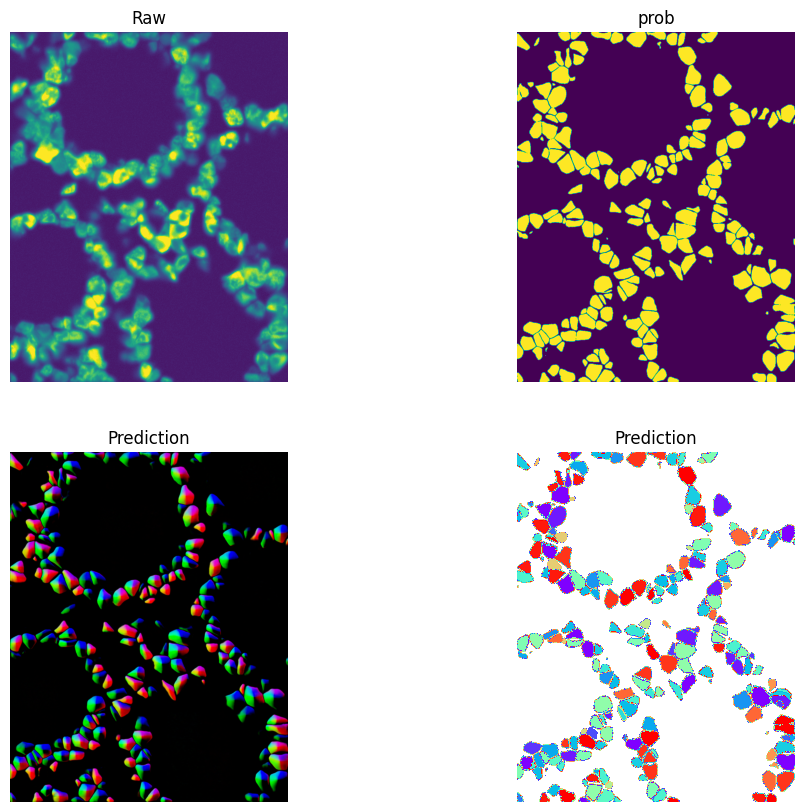

In [16]:
from swincell.utils.plot_utils import get_random_cmap
n_row = 2
fig, axes = plt.subplots(2, 2,sharex=False, sharey=False, figsize=(12,10))
img_shape = logits.shape
slice2view = int(img_shape[-1]//2)
print('slice to view',slice2view)
# datai = next(iter(test_loader))
img=np.squeeze(data_test.detach().cpu().numpy())
print(img.shape,logits_out.shape)
flow= logits_out[1:4]
flow_slice = flow[:,:,:,slice2view].transpose(1, 2, 0)
print(flow.shape)

# print(mask0.max(),mask0.min())
# print('mask2',mask2.max(),mask2.min())
axes[0,0].imshow(img[:,:,slice2view])
axes[0,0].set_title('Raw')

axes[0,1].imshow(logits_out[0,:,:,slice2view])
axes[0,1].set_title('prob')

axes[1,0].imshow(flow_slice)
axes[1,0].set_title('FlowPrediction')

# axes[0,3].imshow(masks_recon[:,:,slice2view])
# axes[0,3].set_title('Prediction')
axes[1,1].imshow(masks_recon[slice2view].T,cmap=get_random_cmap(30))
axes[1,1].set_title('Mask Prediction')

for i in range(2):
    for j in range(2):
        axes[i,j].axis('off')

# vidualize prediction results

In [23]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()